In [1]:
import sys
sys.path.append("../") # go to parent dir

%load_ext autoreload
%autoreload 2

In [101]:
from evrp.utils.utilities import create_optimal_edges, create_json_out, update_instance_json, read_instance_json_str
from evrp.utils.plot import plot_interactive_graph, plot_evrptwv2g
from evrp.milp.evrptw import EVRPTW

import pandas as pd
import numpy as np

import json

pd.options.plotting.backend = "plotly"

In [135]:
instance = 'r105C5_e'
fpath = 'config/test_instances/' + instance + '.csv'

In [158]:
m = EVRPTW(problem_type='Schneider NoXkappaBounds')
m.full_solve(fpath)

2021-02-08 00:57:28 INFO     Building abstract model
2021-02-08 00:57:28 INFO     Defining parameters and sets
2021-02-08 00:57:28 INFO     Defining variables
2021-02-08 00:57:28 INFO     Defining constraints
2021-02-08 00:57:28 INFO     Importing EVRPTW MILP instance: r105C5_e
2021-02-08 00:57:28 INFO     Reading CSV
2021-02-08 00:57:28 INFO     Creating graph
2021-02-08 00:57:28 INFO     Creating timeseries data
2021-02-08 00:57:28 INFO     Creating duplicates and extended graph
2021-02-08 00:57:28 INFO     Calculating distance matrix
2021-02-08 00:57:28 INFO     Creating parameters
2021-02-08 00:57:28 INFO     Creating instance
2021-02-08 00:57:29 INFO     Problem type: Schneider NoXkappaBounds
2021-02-08 00:57:29 INFO     Solving instance...


Using license file /Users/ramiariss/gurobi.lic
Academic license - for non-commercial use only - expires 2021-03-21
Read LP format model from file /var/folders/vv/1p3h17yx43n9m7k86th68_ym0000gn/T/tmpd767yko5.pyomo.lp
Reading time = 0.01 seconds
x452: 345 rows, 449 columns, 1196 nonzeros
Changed value of parameter TimeLimit to 300.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 345 rows, 449 columns and 1196 nonzeros
Model fingerprint: 0x417c94aa
Model has 960 quadratic constraints
Variable types: 178 continuous, 271 integer (271 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+02]
  QMatrix range    [1e+00, 1e+01]
  QLMatrix range   [1e+00, 3e+02]
  Objective range  [4e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
  QRHS range       [2e+00, 2e+02]
Presolve removed 5 rows and 6 columns
Pres

2021-02-08 00:57:30 INFO     Done


In [159]:
print(m.results)


Problem: 
- Name: x452
  Lower bound: 2156.0820694641707
  Upper bound: 2156.0820694641707
  Number of objectives: 1
  Number of constraints: 1305
  Number of variables: 449
  Number of binary variables: 271
  Number of integer variables: 271
  Number of continuous variables: 178
  Number of nonzeros: 1196
  Sense: minimize
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Wall time: 0.880579948425293
  Error rc: 0
  Time: 0.9563689231872559
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



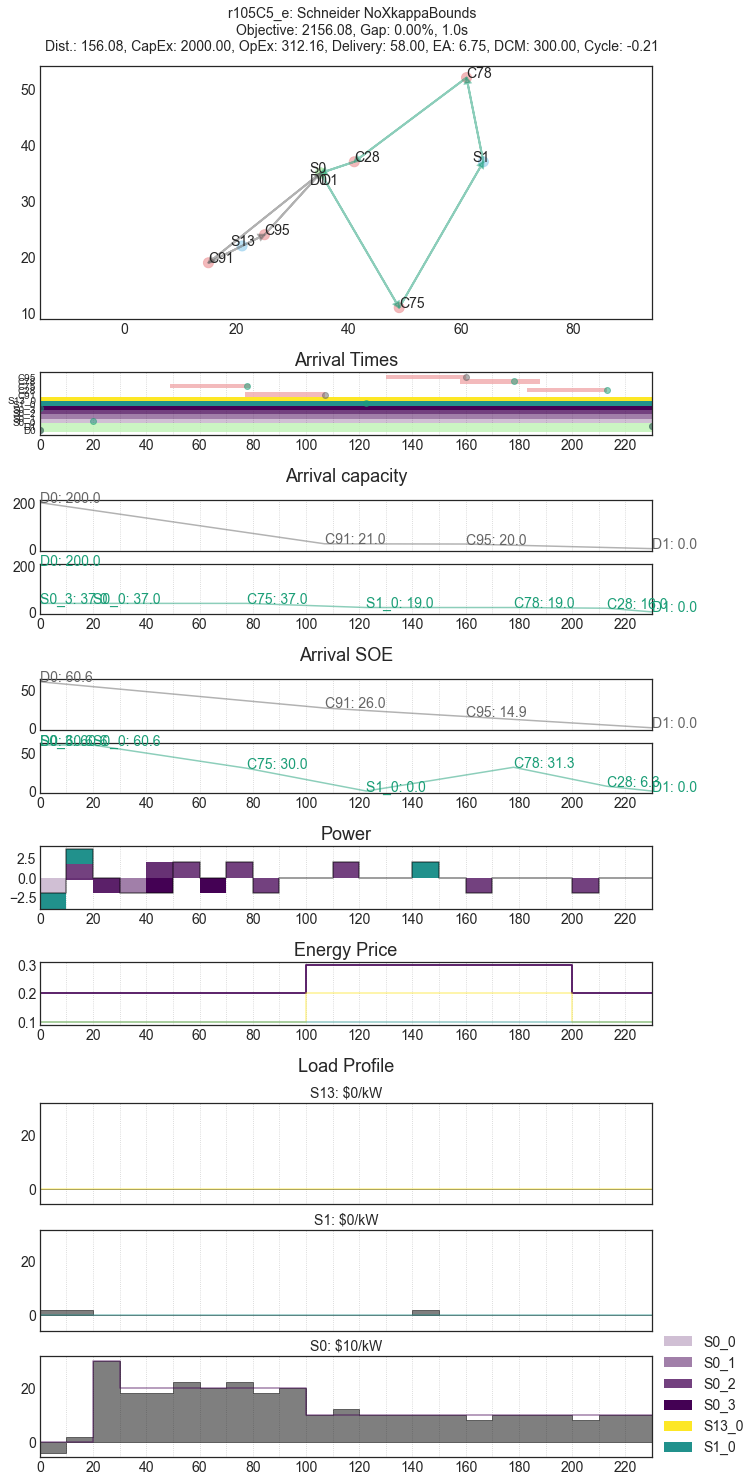

In [160]:
x, xp, traces, routes = plot_evrptwv2g(m)

In [498]:
e, e_flat = create_optimal_edges(m, x=x, graph='V_')

In [ ]:
plot_interactive_graph(m.data['V'], e=e_flat, obj=m.instance.obj(), instance_name=m.instance_name)